In [42]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
# import torchinfo
from tqdm import tqdm
from scipy import signal

## Loading Data

In [2]:
# data_dir = "/Users/rmdim/Documents/MASc/Fall22/599Code/norm_fog_data_2/"
data_dir = "/root/trevor/syde599/norm_fog_data/"

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

In [3]:
data = np.loadtxt(data_files[0], delimiter=",", skiprows=1)
data.shape

(37501, 32)

In [4]:
sample_df = pd.read_csv(data_files[15])

window_size=250
sample_data = np.array(sample_df)
sample_data = sample_data[:sample_data.shape[0]-1, :]
sample_data = sample_data.reshape((-1, window_size, 32))


In [33]:
WINDOW_SIZE = 650
WINDOW_STEP = 100

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]

    # # Split into non-overlapping windows
    # # Don't use the last bit of data that doesn't fill a whole window
    # n_windows = y.size // WINDOW_SIZE
    # end = WINDOW_SIZE * n_windows
    # x = x[:end, :]  # (n_samples, d)
    # y = y[:end]

    # # Reshape into (n_windows, window_size, d)
    # x = x.reshape(n_windows, WINDOW_SIZE, -1)
    # y = y.reshape(n_windows, WINDOW_SIZE)

    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    if patient_num in ('001', '005', '007'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)
    

In [34]:
x.shape

(324, 650, 30)

In [35]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

## Dataset and Augmentation

In [22]:
# class FoGDataset(torch.utils.data.Dataset):
#     def __init__(self, data_x, data_y):
#         """
#         Parameters:
#         -----------
#         data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
#         data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
#         """
#         super().__init__()
#         self.data_x = data_x
#         self.data_y = data_y

#     def _reduce_labels(self, y):
#         """If there is a 1 in the label, then return 1"""
#         return np.any(y == 1, axis=-1).astype(int)

#     def __len__(self):
#         return self.data_x.shape[0]

#     def __getitem__(self, index):
#         """Returns tuple of (data, label) at index"""
#         inputs = self.data_x[index, :, :]
#         labels = self.data_y[index, :]
#         labels = self._reduce_labels(labels)
#         return torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)





In [43]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [37]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)


BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

## Models

In [25]:
class CNNModel(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', batch_size=32):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, stride=2)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)

        self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(41,1) # 41

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.output(x)
        return torch.sigmoid(x)

In [26]:
class ResNet1DLayer(nn.Module):
   def __init__(self, in_channels, channels, stride=1):
       super().__init__()
       conv_kwargs = {
           "kernel_size": (3,),
           "padding": "same",  # To ensure 3x3 conv does not reduce image size. padding=1 also works
           "bias": False
       }
       self.stride = stride
       self.in_channels = in_channels
       self.channels = channels
       self.bn1 = nn.BatchNorm1d(in_channels)
       self.relu = nn.ReLU()
       # This conv is in_channels -> channels and applies stride
       self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=channels, stride=stride,
                           **conv_kwargs)
       self.bn2 = nn.BatchNorm1d(channels)
       # This conv is channels -> channels
       self.conv2 = nn.Conv1d(in_channels=channels, out_channels=channels, **conv_kwargs)
  
   def strided_identity(self, x):
       # Downsample with 'nearest' method (this is striding if dims are divisible by stride)
       # Equivalently x = x[:, :, ::stride, ::stride].contiguous()
       x = nn.functional.interpolate(x, mode='nearest', scale_factor=(1/self.stride))
       # Create padding tensor for extra channels
       (b, c, h) = x.shape
       num_pad_channels = self.channels - self.in_channels
       pad = torch.zeros((b, num_pad_channels, h))
       # Append padding to the downsampled identity
       x = torch.cat((x, pad), dim=1)
       return x

   def forward(self, x):
       if self.stride > 1:
           identity = self.strided_identity(x)
       else:
           identity = x
       z = self.bn1(x)
       z = self.relu(z)
       z = self.conv1(z)
       z = self.bn2(z)
       z = self.relu(z)
       z = self.conv2(z)
       out = identity + z
       return out

In [27]:
class CNNModelRes(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, n = 3, mp=2):
        super().__init__()

        self.n = n

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=1)
        self.mp = nn.MaxPool1d(mp, stride=mp)
        
        self.resBlock1 = ResNet1DLayer(in_channels=32, channels=32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2)

        self.resBlock2 = ResNet1DLayer(in_channels=64, channels=64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        
        self.resBlock3 = ResNet1DLayer(in_channels=128, channels=128)

        self.batchLayer = nn.LayerNorm(1920)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(1920,1)
        
     

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.mp(x)
        for i in range(self.n):
            x = self.resBlock1.forward(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.mp(x)
        for i in range(self.n):
            x=self.resBlock2.forward(x)

        x=self.conv3(x)
        x = F.relu(x)
        x = self.mp(x)
        for i in range(self.n):
            x=self.resBlock3.forward(x)

        x = torch.flatten(x, 1)
        x = self.batchLayer(x)
        x= F.relu(x)
        x = self.dropout(x)
        x = self.linear(x)
        
        return x




In [28]:
model = CNNModelRes()
print(model)

CNNModelRes(
  (conv1): Conv1d(30, 32, kernel_size=(1,), stride=(1,))
  (mp): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resBlock1): ResNet1DLayer(
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  )
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (resBlock2): ResNet1DLayer(
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=sa

## Train and Test Functions

In [44]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.permute(0,2,1)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        # print(f'input shape: {inputs.shape}')
        # print(f'output shape: {outputs.shape}')
        outputs = outputs.flatten()
        
        # print(f'output shape after flatten: {outputs.shape}')
        # print(f'target shape: {targets.shape}')

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
       


        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [39]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.permute(0,2,1)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

## Running the Model

In [45]:
EPOCHS = 10

model = CNNModelRes(30, n=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss() 


In [46]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch, logging_steps=100)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)

0it [00:00, ?it/s]/tmp/ipykernel_124870/2142566481.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  collated_inputs = torch.tensor(x, dtype=torch.float32)
1it [00:03,  3.13s/it]

Epoch: 0 (0/831) Training loss: 0.7022114992141724


102it [00:23,  5.08it/s]

Epoch: 0 (100/831) Training loss: 0.43307191133499146


201it [00:43,  5.03it/s]

Epoch: 0 (200/831) Training loss: 0.3359691798686981


302it [01:03,  5.04it/s]

Epoch: 0 (300/831) Training loss: 0.4322100877761841


401it [01:23,  4.87it/s]

Epoch: 0 (400/831) Training loss: 0.38128435611724854


502it [01:43,  5.07it/s]

Epoch: 0 (500/831) Training loss: 0.3954620361328125


601it [02:03,  4.97it/s]

Epoch: 0 (600/831) Training loss: 0.25376999378204346


701it [02:23,  4.97it/s]

Epoch: 0 (700/831) Training loss: 0.24432459473609924


801it [02:43,  4.92it/s]

Epoch: 0 (800/831) Training loss: 0.24225613474845886


831it [02:49,  4.91it/s]


Epoch 0 done. Training loss: 0.364945650100708 Training accuracy: 0.8415688872337341


136it [00:21,  6.41it/s]


Epoch 0 done. Eval loss: 0.6874187588691711 Eval accuracy: 0.6456801295280457


2it [00:00,  4.97it/s]

Epoch: 1 (0/831) Training loss: 0.2312813550233841


102it [00:20,  5.14it/s]

Epoch: 1 (100/831) Training loss: 0.23066911101341248


201it [00:39,  4.88it/s]

Epoch: 1 (200/831) Training loss: 0.27441176772117615


302it [01:00,  5.08it/s]

Epoch: 1 (300/831) Training loss: 0.4598763883113861


401it [01:19,  5.02it/s]

Epoch: 1 (400/831) Training loss: 0.3633812963962555


502it [01:39,  5.13it/s]

Epoch: 1 (500/831) Training loss: 0.2205388993024826


601it [01:59,  5.13it/s]

Epoch: 1 (600/831) Training loss: 0.2495383769273758


702it [02:19,  5.15it/s]

Epoch: 1 (700/831) Training loss: 0.3160955011844635


801it [02:39,  5.03it/s]

Epoch: 1 (800/831) Training loss: 0.2454945296049118


831it [02:49,  4.89it/s]


Epoch 1 done. Training loss: 0.2740548253059387 Training accuracy: 0.8855859041213989


136it [00:21,  6.40it/s]


Epoch 1 done. Eval loss: 0.689625084400177 Eval accuracy: 0.6729090213775635


1it [00:00,  2.15it/s]

Epoch: 2 (0/831) Training loss: 0.2889285087585449


101it [00:24,  4.97it/s]

Epoch: 2 (100/831) Training loss: 0.28505027294158936


201it [00:44,  4.99it/s]

Epoch: 2 (200/831) Training loss: 0.2972636818885803


302it [01:04,  5.09it/s]

Epoch: 2 (300/831) Training loss: 0.22318166494369507


402it [01:25,  5.02it/s]

Epoch: 2 (400/831) Training loss: 0.2613120675086975


501it [01:44,  5.00it/s]

Epoch: 2 (500/831) Training loss: 0.2074659913778305


601it [02:04,  5.07it/s]

Epoch: 2 (600/831) Training loss: 0.15057086944580078


701it [02:24,  4.96it/s]

Epoch: 2 (700/831) Training loss: 0.34445494413375854


802it [02:45,  5.09it/s]

Epoch: 2 (800/831) Training loss: 0.16275595128536224


831it [02:50,  4.87it/s]


Epoch 2 done. Training loss: 0.2468259185552597 Training accuracy: 0.8977888226509094


136it [00:21,  6.41it/s]


Epoch 2 done. Eval loss: 0.6261889338493347 Eval accuracy: 0.6754365563392639


2it [00:00,  5.00it/s]

Epoch: 3 (0/831) Training loss: 0.2029496431350708


102it [00:20,  5.07it/s]

Epoch: 3 (100/831) Training loss: 0.22345910966396332


202it [00:40,  4.98it/s]

Epoch: 3 (200/831) Training loss: 0.11989489197731018


301it [01:00,  4.97it/s]

Epoch: 3 (300/831) Training loss: 0.3893105685710907


401it [01:20,  4.92it/s]

Epoch: 3 (400/831) Training loss: 0.35094618797302246


501it [01:40,  5.12it/s]

Epoch: 3 (500/831) Training loss: 0.21717751026153564


602it [02:00,  5.05it/s]

Epoch: 3 (600/831) Training loss: 0.1800590455532074


701it [02:20,  5.12it/s]

Epoch: 3 (700/831) Training loss: 0.19034598767757416


801it [02:40,  5.07it/s]

Epoch: 3 (800/831) Training loss: 0.1653841733932495


831it [02:46,  4.99it/s]


Epoch 3 done. Training loss: 0.22554656863212585 Training accuracy: 0.9064192175865173


136it [00:21,  6.43it/s]


Epoch 3 done. Eval loss: 0.6040501594543457 Eval accuracy: 0.7027803063392639


1it [00:00,  4.76it/s]

Epoch: 4 (0/831) Training loss: 0.2310725897550583


101it [00:20,  4.78it/s]

Epoch: 4 (100/831) Training loss: 0.15734800696372986


201it [00:40,  5.06it/s]

Epoch: 4 (200/831) Training loss: 0.14343811571598053


302it [01:00,  5.12it/s]

Epoch: 4 (300/831) Training loss: 0.3653542399406433


402it [01:20,  5.11it/s]

Epoch: 4 (400/831) Training loss: 0.2209469974040985


502it [01:40,  5.03it/s]

Epoch: 4 (500/831) Training loss: 0.35361096262931824


601it [02:00,  5.04it/s]

Epoch: 4 (600/831) Training loss: 0.20778433978557587


702it [02:20,  5.18it/s]

Epoch: 4 (700/831) Training loss: 0.2862609028816223


802it [02:40,  5.16it/s]

Epoch: 4 (800/831) Training loss: 0.1355416625738144


831it [02:45,  5.01it/s]


Epoch 4 done. Training loss: 0.20711810886859894 Training accuracy: 0.915557324886322


136it [00:21,  6.41it/s]


Epoch 4 done. Eval loss: 0.8470120429992676 Eval accuracy: 0.5814567804336548


2it [00:00,  5.13it/s]

Epoch: 5 (0/831) Training loss: 0.20615556836128235


101it [00:20,  5.01it/s]

Epoch: 5 (100/831) Training loss: 0.28522711992263794


202it [00:40,  5.17it/s]

Epoch: 5 (200/831) Training loss: 0.22895817458629608


302it [01:00,  5.14it/s]

Epoch: 5 (300/831) Training loss: 0.2960282564163208


401it [01:20,  4.88it/s]

Epoch: 5 (400/831) Training loss: 0.2721713185310364


501it [01:40,  4.97it/s]

Epoch: 5 (500/831) Training loss: 0.15378642082214355


601it [02:00,  5.01it/s]

Epoch: 5 (600/831) Training loss: 0.12499235570430756


701it [02:20,  4.99it/s]

Epoch: 5 (700/831) Training loss: 0.30892372131347656


802it [02:40,  4.98it/s]

Epoch: 5 (800/831) Training loss: 0.225697860121727


831it [02:45,  5.01it/s]


Epoch 5 done. Training loss: 0.19131878018379211 Training accuracy: 0.9215929508209229


136it [00:21,  6.41it/s]


Epoch 5 done. Eval loss: 0.6893659234046936 Eval accuracy: 0.6799172759056091


2it [00:00,  5.03it/s]

Epoch: 6 (0/831) Training loss: 0.2293022871017456


101it [00:20,  5.07it/s]

Epoch: 6 (100/831) Training loss: 0.17350083589553833


202it [00:40,  4.96it/s]

Epoch: 6 (200/831) Training loss: 0.15661901235580444


302it [01:00,  5.07it/s]

Epoch: 6 (300/831) Training loss: 0.09292712062597275


401it [01:20,  5.00it/s]

Epoch: 6 (400/831) Training loss: 0.13564017415046692


502it [01:40,  5.03it/s]

Epoch: 6 (500/831) Training loss: 0.23693905770778656


602it [02:00,  5.11it/s]

Epoch: 6 (600/831) Training loss: 0.10600960999727249


702it [02:20,  5.06it/s]

Epoch: 6 (700/831) Training loss: 0.1658063381910324


801it [02:39,  5.08it/s]

Epoch: 6 (800/831) Training loss: 0.1938466578722


831it [02:45,  5.02it/s]


Epoch 6 done. Training loss: 0.17714986205101013 Training accuracy: 0.9281174540519714


136it [00:21,  6.44it/s]


Epoch 6 done. Eval loss: 0.7250509262084961 Eval accuracy: 0.6918658018112183


1it [00:00,  5.18it/s]

Epoch: 7 (0/831) Training loss: 0.12585251033306122


102it [00:20,  5.05it/s]

Epoch: 7 (100/831) Training loss: 0.10212473571300507


202it [00:40,  5.06it/s]

Epoch: 7 (200/831) Training loss: 0.31812170147895813


301it [01:00,  5.00it/s]

Epoch: 7 (300/831) Training loss: 0.12991386651992798


402it [01:20,  5.14it/s]

Epoch: 7 (400/831) Training loss: 0.1735658496618271


501it [01:39,  5.00it/s]

Epoch: 7 (500/831) Training loss: 0.19909904897212982


601it [01:59,  5.01it/s]

Epoch: 7 (600/831) Training loss: 0.21836689114570618


701it [02:19,  4.83it/s]

Epoch: 7 (700/831) Training loss: 0.19419190287590027


802it [02:40,  5.13it/s]

Epoch: 7 (800/831) Training loss: 0.14410625398159027


831it [02:45,  5.02it/s]


Epoch 7 done. Training loss: 0.16381056606769562 Training accuracy: 0.9333634376525879


136it [00:21,  6.39it/s]


Epoch 7 done. Eval loss: 0.6944552063941956 Eval accuracy: 0.6775045990943909


2it [00:00,  5.02it/s]

Epoch: 8 (0/831) Training loss: 0.15522374212741852


102it [00:20,  4.99it/s]

Epoch: 8 (100/831) Training loss: 0.22382499277591705


201it [00:40,  4.87it/s]

Epoch: 8 (200/831) Training loss: 0.261109322309494


302it [01:00,  5.07it/s]

Epoch: 8 (300/831) Training loss: 0.15105652809143066


401it [01:20,  4.91it/s]

Epoch: 8 (400/831) Training loss: 0.1935359686613083


501it [01:40,  4.88it/s]

Epoch: 8 (500/831) Training loss: 0.2056395709514618


601it [02:00,  4.98it/s]

Epoch: 8 (600/831) Training loss: 0.1751619428396225


701it [02:20,  5.11it/s]

Epoch: 8 (700/831) Training loss: 0.1625874638557434


801it [02:39,  5.01it/s]

Epoch: 8 (800/831) Training loss: 0.21923479437828064


831it [02:45,  5.01it/s]


Epoch 8 done. Training loss: 0.1510220766067505 Training accuracy: 0.9406024217605591


136it [00:21,  6.42it/s]


Epoch 8 done. Eval loss: 0.7782796621322632 Eval accuracy: 0.6852021813392639


1it [00:00,  4.93it/s]

Epoch: 9 (0/831) Training loss: 0.2800663113594055


101it [00:20,  4.90it/s]

Epoch: 9 (100/831) Training loss: 0.10539191961288452


202it [00:40,  5.02it/s]

Epoch: 9 (200/831) Training loss: 0.15794014930725098


302it [01:00,  5.08it/s]

Epoch: 9 (300/831) Training loss: 0.16377799212932587


402it [01:20,  5.06it/s]

Epoch: 9 (400/831) Training loss: 0.1123078390955925


501it [01:40,  4.95it/s]

Epoch: 9 (500/831) Training loss: 0.07380279153585434


601it [02:00,  4.88it/s]

Epoch: 9 (600/831) Training loss: 0.15277892351150513


702it [02:20,  4.97it/s]

Epoch: 9 (700/831) Training loss: 0.25732365250587463


801it [02:40,  5.06it/s]

Epoch: 9 (800/831) Training loss: 0.3017506003379822


831it [02:45,  5.01it/s]


Epoch 9 done. Training loss: 0.1450224220752716 Training accuracy: 0.9406964778900146


136it [00:21,  6.39it/s]

Epoch 9 done. Eval loss: 0.7594918012619019 Eval accuracy: 0.6494715213775635


## Graphing the Loss and Accuracy

In [48]:
import matplotlib.pyplot as plt

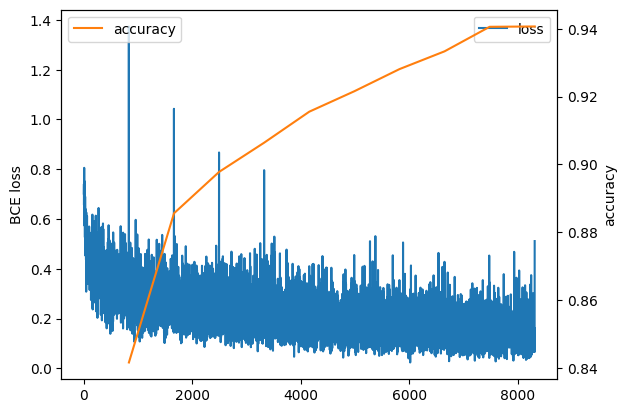

In [49]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

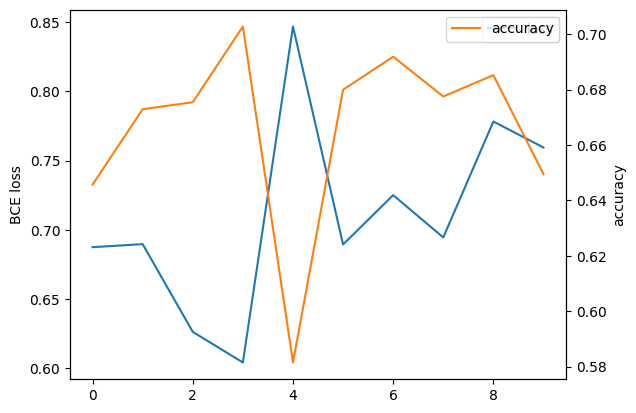

In [50]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [51]:
eval_acc_history

[tensor(0.6457),
 tensor(0.6729),
 tensor(0.6754),
 tensor(0.7028),
 tensor(0.5815),
 tensor(0.6799),
 tensor(0.6919),
 tensor(0.6775),
 tensor(0.6852),
 tensor(0.6495)]